# Next Token Vorhersage – Rechenbeispiel (wie auf der Folie)

Wir verwenden den **Kontextvektor nach Attention** (z. B. für das aktuelle Token „von“):

$$
h = [0.304,\ 0.529,\ 0.603,\ 0.399]
$$

Mini-Vokabular:
$$
V = \{\text{Frankreich},\ \text{Deutschland},\ \text{Spanien}\}
$$

Lineare Projektion (vereinfacht):
$$
z = W_{out}\,h + b
$$

Dann Softmax:
$$
p(token) = \frac{e^{z_{token}}}{\sum_k e^{z_k}}
$$

Zusätzlich enthält dieses Notebook:
- **Schritt-für-Schritt-Ausgabe** (für Live-Demo)
- **Balkendiagramm** der Softmax-Wahrscheinlichkeiten


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)


## Schritt 0: Voraussetzungen (h + Mini-Vokabular + $W_out$)

Gewichtungsvektoren (Zeilen in $W_{out}$) wie auf der Folie:

- Frankreich: $[1.0,\ 0.5,\ 1.0,\ 0.5]$
- Deutschland: $[0.0,\ 1.0,\ 0.0,\ 1.0]$
- Spanien: $[1.0,\ 0.0,\ 1.0,\ 0.0]$

Bias \(b\) setzen wir hier der Einfachheit halber auf 0.

In [2]:
h = np.array([0.304, 0.529, 0.603, 0.399], dtype=float)

vocab = ["Frankreich", "Deutschland", "Spanien"]

W_out = {
    "Frankreich":  np.array([1.0, 0.5, 1.0, 0.5], dtype=float),
    "Deutschland": np.array([0.0, 1.0, 0.0, 1.0], dtype=float),
    "Spanien":     np.array([1.0, 0.0, 1.0, 0.0], dtype=float)
}

b = {t: 0.0 for t in vocab}

df_W = pd.DataFrame({t: W_out[t] for t in vocab}).T
df_W.columns = ["w1", "w2", "w3", "w4"]
df_W


,w1,w2,w3,w4
Frankreich,1.0,0.5,1.0,0.5
Deutschland,0.0,1.0,0.0,1.0
Spanien,1.0,0.0,1.0,0.0


## Schritt 1: Logits berechnen

Für jedes Token:
$$
z_{token} = W_{out,token} \cdot h + b_{token}
$$


In [3]:
logits = {}
for t in vocab:
    logits[t] = float(W_out[t] @ h + b[t])

df_logits = pd.DataFrame({"Logit z": [logits[t] for t in vocab]}, index=vocab)
df_logits


,Logit z
Frankreich,1.371
Deutschland,0.928
Spanien,0.907


## Schritt 2: Exponentialwerte $e^z$ und Summe

In [4]:
exp_vals = {t: float(np.exp(logits[t])) for t in vocab}
sum_exp = float(sum(exp_vals.values()))

df_exp = pd.DataFrame({
    "Logit z": [logits[t] for t in vocab],
    "e^z": [exp_vals[t] for t in vocab]
}, index=vocab)

df_exp.loc["Summe", "e^z"] = sum_exp
df_exp


,Logit z,e^z
Frankreich,1.371,3.939288
Deutschland,0.928,2.529445
Spanien,0.907,2.476881
Summe,NaN,8.945614


## Schritt 3: Softmax-Wahrscheinlichkeiten

$$
p(token) = \frac{e^{z_{token}}}{\sum_k e^{z_k}}
$$


In [5]:
probs = {t: exp_vals[t] / sum_exp for t in vocab}

df_probs = pd.DataFrame({
    "Logit z": [logits[t] for t in vocab],
    "Softmax p": [probs[t] for t in vocab]
}, index=vocab)
df_probs


,Logit z,Softmax p
Frankreich,1.371,0.440360
Deutschland,0.928,0.282758
Spanien,0.907,0.276882


## Ergebnis: nächstes Token (argmax)

In [6]:
next_token = max(probs, key=probs.get)
print("Nächstes Token (höchste Wahrscheinlichkeit):", next_token)
print("Wahrscheinlichkeit:", round(probs[next_token], 3))


Nächstes Token (höchste Wahrscheinlichkeit): Frankreich
Wahrscheinlichkeit: 0.44


# Zusatz A: Schritt-für-Schritt-Ausgabe (für Live-Demo)

Diese Zelle gibt jede Zwischenrechnung so aus, dass du sie direkt vorlesen kannst.

In [7]:
def fmt(v, nd=3):
    return "[" + ", ".join(f"{x:.{nd}f}" for x in v) + "]"

print("="*72)
print("NEXT TOKEN VORHERSAGE – Schritt für Schritt")
print("="*72)
print("Gegeben: h =", fmt(h, 3))
print("Vokabular:", vocab)

print("\nSchritt 1: Logits z = W_out · h + b (hier b=0)")
for t in vocab:
    w = W_out[t]
    terms = w * h
    z = logits[t]
    print(f"\nToken: {t}")
    print("  w       =", fmt(w, 3))
    print("  w ⊙ h   =", fmt(terms, 3), "(elementweise Produkte)")
    print("  z       = sum(w_i*h_i) =", f"{z:.3f}")

print("\nSchritt 2: Exponentialwerte")
for t in vocab:
    print(f"  e^{logits[t]:.3f} = {exp_vals[t]:.3f}")
print("  Summe =", f"{sum_exp:.3f}")

print("\nSchritt 3: Softmax")
for t in vocab:
    print(f"  p({t}) = {exp_vals[t]:.3f}/{sum_exp:.3f} = {probs[t]:.3f}")

print("\nErgebnis:")
print("  nächstes Token =", next_token)
print("  p              =", f"{probs[next_token]:.3f}")
print("="*72)


NEXT TOKEN VORHERSAGE – Schritt für Schritt
Gegeben: h = [0.304, 0.529, 0.603, 0.399]
Vokabular: ['Frankreich', 'Deutschland', 'Spanien']

Schritt 1: Logits z = W_out · h + b (hier b=0)

Token: Frankreich
  w       = [1.000, 0.500, 1.000, 0.500]
  w ⊙ h   = [0.304, 0.265, 0.603, 0.200] (elementweise Produkte)
  z       = sum(w_i*h_i) = 1.371

Token: Deutschland
  w       = [0.000, 1.000, 0.000, 1.000]
  w ⊙ h   = [0.000, 0.529, 0.000, 0.399] (elementweise Produkte)
  z       = sum(w_i*h_i) = 0.928

Token: Spanien
  w       = [1.000, 0.000, 1.000, 0.000]
  w ⊙ h   = [0.304, 0.000, 0.603, 0.000] (elementweise Produkte)
  z       = sum(w_i*h_i) = 0.907

Schritt 2: Exponentialwerte
  e^1.371 = 3.939
  e^0.928 = 2.529
  e^0.907 = 2.477
  Summe = 8.946

Schritt 3: Softmax
  p(Frankreich) = 3.939/8.946 = 0.440
  p(Deutschland) = 2.529/8.946 = 0.283
  p(Spanien) = 2.477/8.946 = 0.277

Ergebnis:
  nächstes Token = Frankreich
  p              = 0.440


# Zusatz B: Mini-Visualisierung (Softmax-Wahrscheinlichkeiten)

Balkendiagramm der Wahrscheinlichkeiten für die Kandidaten.

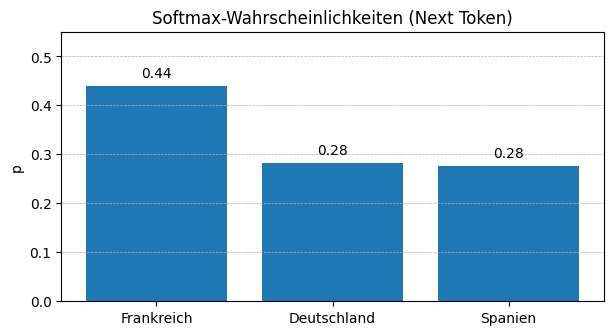

In [8]:
labels = vocab
values = np.array([probs[t] for t in vocab], dtype=float)

order = np.argsort(values)[::-1]
labels_sorted = [labels[i] for i in order]
values_sorted = values[order]

plt.figure(figsize=(7, 3.5))
plt.bar(labels_sorted, values_sorted)
plt.title("Softmax-Wahrscheinlichkeiten (Next Token)")
plt.ylabel("p")
plt.ylim(0, float(max(values_sorted) * 1.25))
plt.grid(axis="y", linestyle="--", linewidth=0.5)

for i, v in enumerate(values_sorted):
    plt.text(i, float(v) + 0.01, f"{float(v):.2f}", ha="center", va="bottom")

plt.show()


## Kompakte Tabelle (Token | Logit | $e^z$ | Softmax)

Sortiert nach Wahrscheinlichkeit (wie auf der Folie).

In [9]:
df_final = pd.DataFrame({
    "Logit z": [logits[t] for t in vocab],
    "e^z": [exp_vals[t] for t in vocab],
    "Softmax p": [probs[t] for t in vocab]
}, index=vocab)

df_final.sort_values("Softmax p", ascending=False)


,Logit z,e^z,Softmax p
Frankreich,1.371,3.939288,0.440360
Deutschland,0.928,2.529445,0.282758
Spanien,0.907,2.476881,0.276882
